# Final Project
### Scientific Computing
### Ethan Witkowski

In [120]:
#Data structures packages
import numpy as np
import pandas as pd
import itertools
import math

#Statistical packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from linearmodels import PooledOLS

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Import .dta dataset
data = pd.read_stata(r'C:\Users\ethan\Desktop\Swarthmore\Fall 2019\Scientific Computing\Final Project\CMPS Data\1ccn3rdg2_145441\BCMC_CMPS\CMPS Bell Cingranelli Murdie replication file quarterly dataset from online appendix.dta', convert_dates=True, convert_categoricals=True)

In [3]:
#display(data.columns.values)
#display(data)

### Function to match observations with numeric time

In [4]:
'''
Panel data is formatted with one column as 'year' and another as 'quarter' -- there is no \
running time from 1990 to 2009
'''

try:
    def running_time(data):
        
        #Create running time column from 1990 to 2009
        time = np.empty(len(data.quarter))

        #Declare lists of quarters and translation to numeric quarters
        quarter_list = np.arange(1,5)
        translation_list = np.array([.25, .5, .75, .99])

        for i,quarter in enumerate(data.quarter):

            for j,comp_q in enumerate(quarter_list):

                #If the quarter value in dataset is same as quarter_list, assign time value as (year + numeric quarter)
                if (data.quarter[i] == comp_q):
                    time[i] = data.year[i] + translation_list[j]
    
        return time
        
except:
    Print('Error occurred')

In [5]:
#Execute funtion running_time, add time to dataframes
time = running_time(data)
data['time'] = time

### Drop observation if country not included in study

In [39]:
#List of western nations to be included in study
country_list = ['France', 'United States', 'Canada', 'Spain', 'Sweden', 'Belgium', 'Netherlands', 'Finland', 'Germany', \
               'United Kingdom', 'Norway', 'Denmark']

df = data[data['country'].isin(country_list)]

### Obtains number of violent protests in each country for each quarter

In [40]:
'''
Important point: not all countries have the same time span for which the number of violent protests were recorded \
and placeholder values were not used in the creation of the original dataset

If quarterly placeholders were used, numpy comparison arrays would've been more efficient data structures
'''

'''
Holding lists: 
-Violent protests per country at given quarter 
-Quarter/time for each measurement of violent protests per country
-Percentage of Internet Users in country at given quarter
-Percentage of Mobile Phone subscribers in country at given quarter
'''

country_vprotests = []
time_vprotests = []
internet_users = []
mobile_subs = []


#For each unique country
for i, u_country in enumerate(country_list):
    
    #Sub-lists for each variable
    vprotests_per_country = []
    time_stamp = []
    internet_per_country = []
    mobile_per_country = []

    #For each observation in dataset
    for j,country in enumerate(data.country):
        
        #Append specified observation data if country matches country list
        if country == u_country:
            vprotests_per_country.append(data.violprot[j])
            time_stamp.append(data.time[j])
            internet_per_country.append(data.internet_user_imputed[j])
            mobile_per_country.append(data.mobile_sub_imputed[j])
            
            
    #Append each countries' data to inter-nation lists
    country_vprotests.append(vprotests_per_country)
    time_vprotests.append(time_stamp)
    internet_users.append(internet_per_country)
    mobile_subs.append(mobile_per_country)

### Exploratory Data Visualization

<function matplotlib.pyplot.show(*args, **kw)>

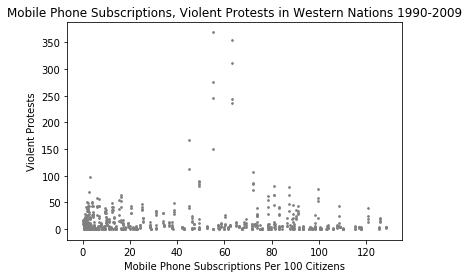

In [126]:
#Cross-sectional percent of Mobile subscribers, violent protests

for k, num_vprotests in enumerate(country_vprotests):

    plt.scatter(mobile_subs[k], num_vprotests, s=3, color='gray')

plt.xlabel('Mobile Phone Subscriptions Per 100 Citizens')
plt.ylabel('Violent Protests')
plt.title('Mobile Phone Subscriptions, Violent Protests in Western Nations 1990-2009')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

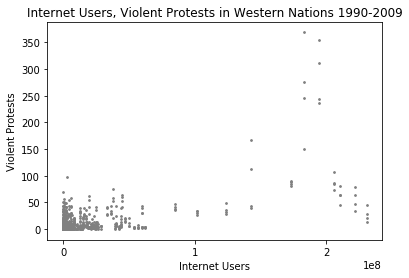

In [127]:
#Cross-sectional percent of internet users, violent protests

for k, num_vprotests in enumerate(country_vprotests):

    plt.scatter(internet_users[k], num_vprotests, s=3, color='grey')

plt.xlabel('Internet Users')
plt.ylabel('Violent Protests')
plt.title('Internet Users, Violent Protests in Western Nations 1990-2009')
plt.xticks(np.arange(0, 300000000, 100000000))

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

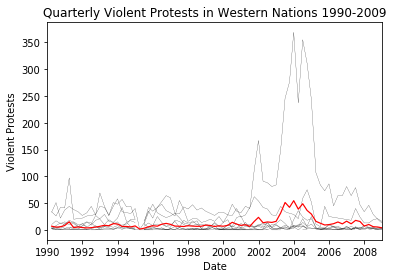

In [108]:
#Time Series violent protests, comparison to mean

#Mean number of protests across all countries for each quarter

#Unique times sorted
unique_time = list(set(time))
unique_time.sort()
unique_time = np.array(unique_time)

#List to hold all countries' quarter values
quarterly_violent_protests = []

for k,quarter in enumerate(unique_time):
    
    #List for each quarter
    quarterly_vp = []
    
    for j,obs in enumerate(df.time):
        
        if quarter==obs:
            quarterly_vp.append(data.violprot[j])
    
    quarterly_violent_protests.append(quarterly_vp)

#Array that holds all countries' violent protest values for each quarter
np_quarterly_violent_protests = np.array([np.array(xi) for xi in quarterly_violent_protests])

#List to hold mean number of violent protests each quarter
mean_quarterly_violent_protests = []

for i,quarter in enumerate(np_quarterly_violent_protests):
    mean_quarterly_violent_protests.append(np.nanmean(quarter))


#Visualize
for i,vpro in enumerate(country_vprotests):
    plt.plot(time_vprotests[i], vpro, color='black', linewidth = .2)
    
plt.plot(unique_time, mean_quarterly_violent_protests, color='red', linewidth = 1.2)

plt.xlabel('Date')
plt.ylabel('Violent Protests')
plt.title('Quarterly Violent Protests in Western Nations 1990-2009')
plt.xlim(1990,2009)
plt.xticks(np.arange(1990, 2009, 2.0))

plt.show

### Statistical Modeling

In [76]:
#Panel data preparation

#Copy dataset
df_panel = df.copy()

#Merge country rows
time = pd.Categorical(df_panel.time)
df_panel = df_panel.set_index(['country', 'time'])
df_panel['time'] = time

In [77]:
#Pooled ordinary least squares regression for panel data

#Declare list of regressors
exog_vars = ['tort3',  'kill3', 'disap3', 'polpris3', 'assn3',  'ef_impute',  'lngdppercap', 'mobile_sub_imputed', 'internet_user_imputed', 'mil_pers_tot_imputed', 'lnpop', 'polity2', 'lncoverage']

#Add regressors to panel
exog = sm.add_constant(df_panel[exog_vars])

#Fit model
mod = PooledOLS(df_panel.violprot, exog)
pooled_res = mod.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               violprot   R-squared:                        0.5712
Estimator:                  PooledOLS   R-squared (Between):              0.9660
No. Observations:                 668   R-squared (Within):               0.3068
Date:                Sat, Dec 07 2019   R-squared (Overall):              0.5712
Time:                        23:33:25   Log-likelihood                   -3032.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      67.016
Entities:                          12   P-value                           0.0000
Avg Obs:                       55.667   Distribution:                  F(13,654)
Min Obs:                       7.0000                                           
Max Obs:                       76.000   F-statistic (robust):             67.016
                            